In [ ]:
from modAL.models import ActiveLearner
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import matplotlib as mpl
import matplotlib.pyplot as plt
from modAL.uncertainty import entropy_sampling
from modAL.uncertainty import margin_sampling
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import seaborn as sns
%matplotlib inline



# using stroke dataset

In [ ]:
df = pd.read_csv(r"healthcare-dataset-stroke-data.csv")
df.dropna(inplace=True)
df.drop(columns=['id'],inplace=True)
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5104,Female,13.0,0,0,No,children,Rural,103.08,18.6,Unknown,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


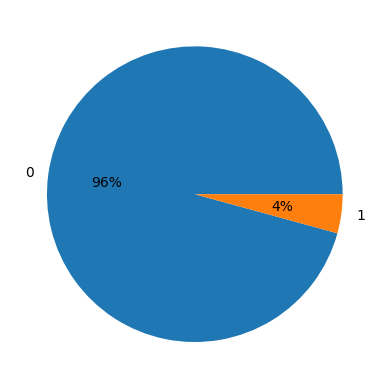

In [ ]:
plt.pie(df['stroke'].value_counts(),labels=[0,1], autopct='%.0f%%')
plt.show();

In [ ]:
df[['gender','ever_married','work_type','Residence_type','smoking_status']] = df[['gender','ever_married','work_type','Residence_type','smoking_status']].apply(lambda x: pd.factorize(x)[0])
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,67.0,0,1,0,0,0,228.69,36.6,0,1
2,0,80.0,0,1,0,0,1,105.92,32.5,1,1
3,1,49.0,0,0,0,0,0,171.23,34.4,2,1
4,1,79.0,1,0,0,1,1,174.12,24.0,1,1
5,0,81.0,0,0,0,0,0,186.21,29.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
5104,1,13.0,0,0,1,3,1,103.08,18.6,3,0
5106,1,81.0,0,0,0,1,0,125.20,40.0,1,0
5107,1,35.0,0,0,0,1,1,82.99,30.6,1,0
5108,0,51.0,0,0,0,0,1,166.29,25.6,0,0


In [ ]:
X_raw= df.drop(columns=['stroke']).values
y_raw= df['stroke'].values

In [ ]:
# Define our PCA transformer and fit it onto our raw dataset
RANDOM_STATE_SEED = 123
np.random.seed(RANDOM_STATE_SEED)
pca = PCA(n_components=2, random_state=RANDOM_STATE_SEED)
transformed = pca.fit_transform(X=X_raw)

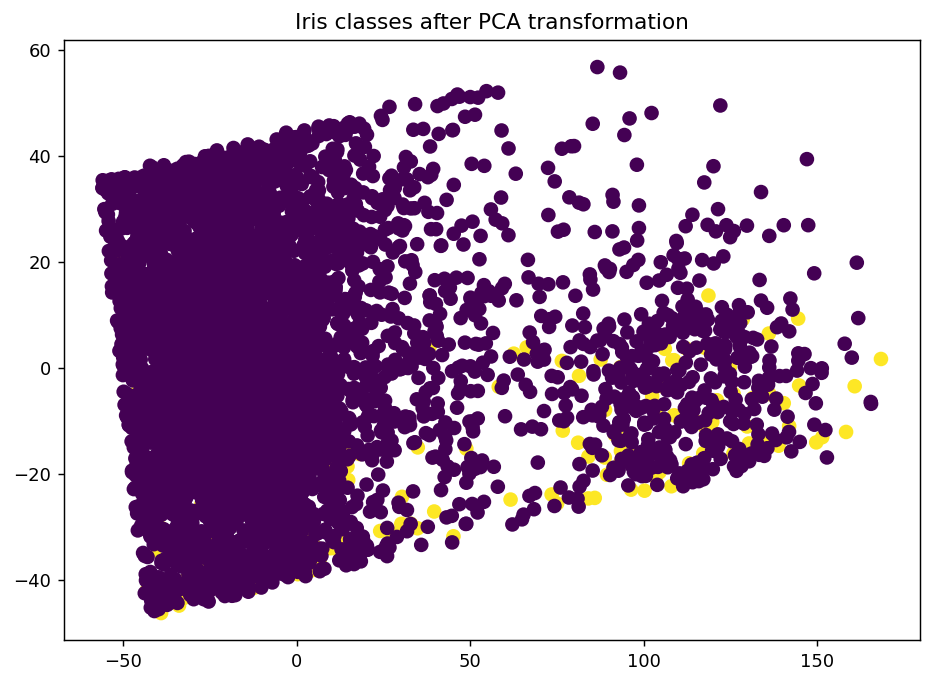

In [ ]:
# Isolate the data we'll need for plotting.
x_component, y_component = transformed[:, 0], transformed[:, 1]

# Plot our dimensionality-reduced (via PCA) dataset.
plt.figure(figsize=(8.5, 6), dpi=130)
plt.scatter(x=x_component, y=y_component, c=y_raw, cmap='viridis', s=50)
plt.title('Iris classes after PCA transformation')
plt.show()

In [ ]:
# Isolate our examples for our labeled dataset.
n_labeled_examples = X_raw.shape[0]
training_indices = np.random.randint(low=0, high=n_labeled_examples, size=10)

X_train = X_raw[training_indices]
y_train = y_raw[training_indices]

# Isolate the non-training examples we'll be querying.
X_pool = np.delete(X_raw, training_indices, axis=0)
y_pool = np.delete(y_raw, training_indices, axis=0)

# Applying Active learning using uncertainity sampling strategy

In [ ]:
# Specify our core estimator along with it's active learning model.
# DT = DecisionTreeClassifier(criterion="entropy", max_depth = 7,min_samples_split=5)
xg = xgb.XGBClassifier(gamma= 1,
 learning_rate= 0.1,
 max_depth= 7,
 reg_lambda= 10,
 scale_pos_weight= 3,
 n_estimators=50)
learner = ActiveLearner(estimator=xg, X_training=X_train, y_training=y_train)

In [ ]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

predictions


array([1, 0, 1, ..., 0, 0, 0])

In [ ]:
f1_score(y_raw,predictions)

0.1888745148771022

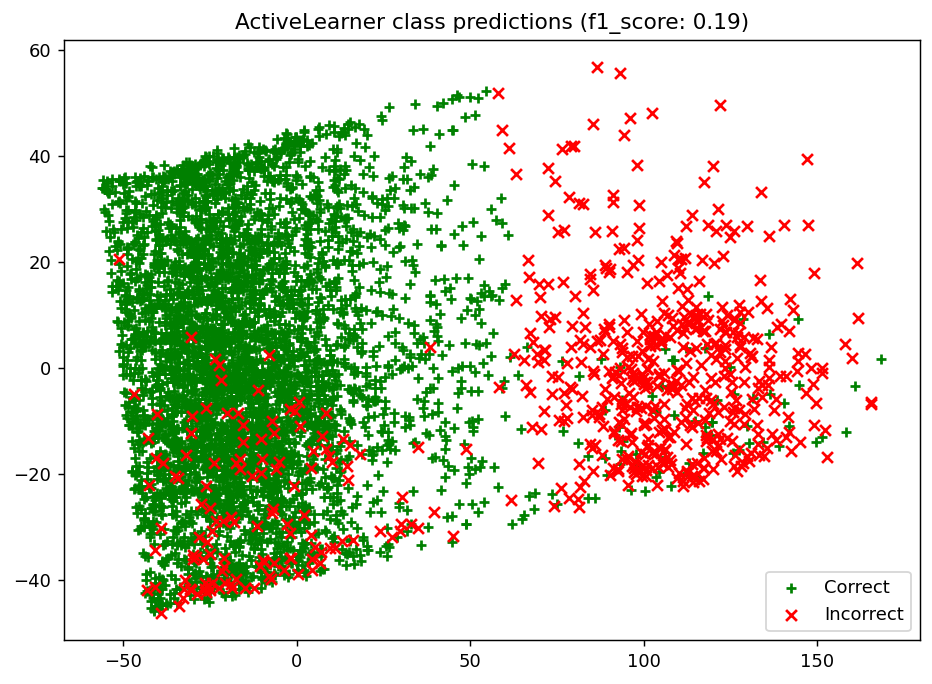

In [ ]:
# Record our learner's score on the raw data.
unqueried_score = f1_score(y_raw, predictions)

# Plot our classification results.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct')
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect')
ax.legend(loc='lower right')
ax.set_title("ActiveLearner class predictions (f1_score: {score:.2f})".format(score=unqueried_score))
plt.show()

In [ ]:
N_QUERIES = 2000
performance_history = [unqueried_score]

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
  query_index, query_instance = learner.query(X_pool)

  # Teach our ActiveLearner model the record it has requested.
  X, y = X_pool[query_index].reshape(1, -1), y_pool[query_index].reshape(1, )
  learner.teach(X=X, y=y)

  # Remove the queried instance from the unlabeled pool.
  X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)

  # Calculate and report our model's accuracy.
  if (index+1==N_QUERIES) or (index%100==0):
    predictions = learner.predict(X_raw)
    model_f = f1_score(y_raw,predictions)
    print('f1_score after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_f))
    model_accuracy = learner.score(X_raw, y_raw)
    print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

    # Save our model's performance for plotting.
    performance_history.append(model_f)

f1_score after query 1: 0.1889
Accuracy after query 1: 0.8723
f1_score after query 101: 0.1161
Accuracy after query 101: 0.3551
f1_score after query 201: 0.1161
Accuracy after query 201: 0.3551
f1_score after query 301: 0.1443
Accuracy after query 301: 0.4997
f1_score after query 401: 0.1474
Accuracy after query 401: 0.5264
f1_score after query 501: 0.1474
Accuracy after query 501: 0.5264
f1_score after query 601: 0.1637
Accuracy after query 601: 0.6003
f1_score after query 701: 0.1793
Accuracy after query 701: 0.6549
f1_score after query 801: 0.2069
Accuracy after query 801: 0.7299
f1_score after query 901: 0.2230
Accuracy after query 901: 0.7629
f1_score after query 1001: 0.2460
Accuracy after query 1001: 0.8002
f1_score after query 1101: 0.2889
Accuracy after query 1101: 0.8586
f1_score after query 1201: 0.3365
Accuracy after query 1201: 0.9004
f1_score after query 1301: 0.3874
Accuracy after query 1301: 0.9246
f1_score after query 1401: 0.4092
Accuracy after query 1401: 0.9318
f1_s

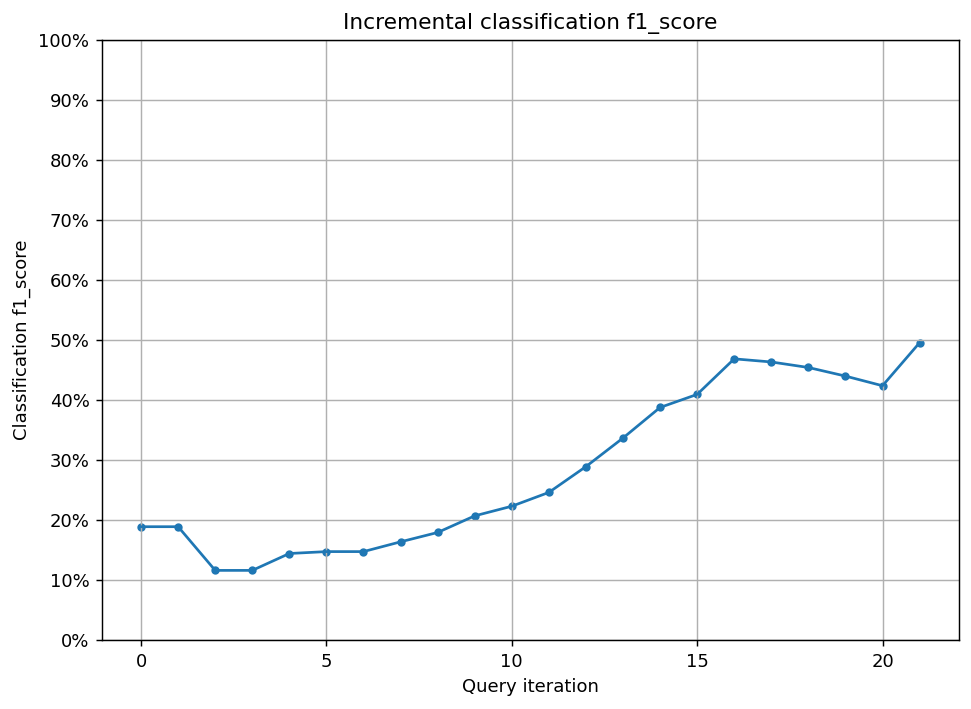

In [ ]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification f1_score')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification f1_score')

plt.show()

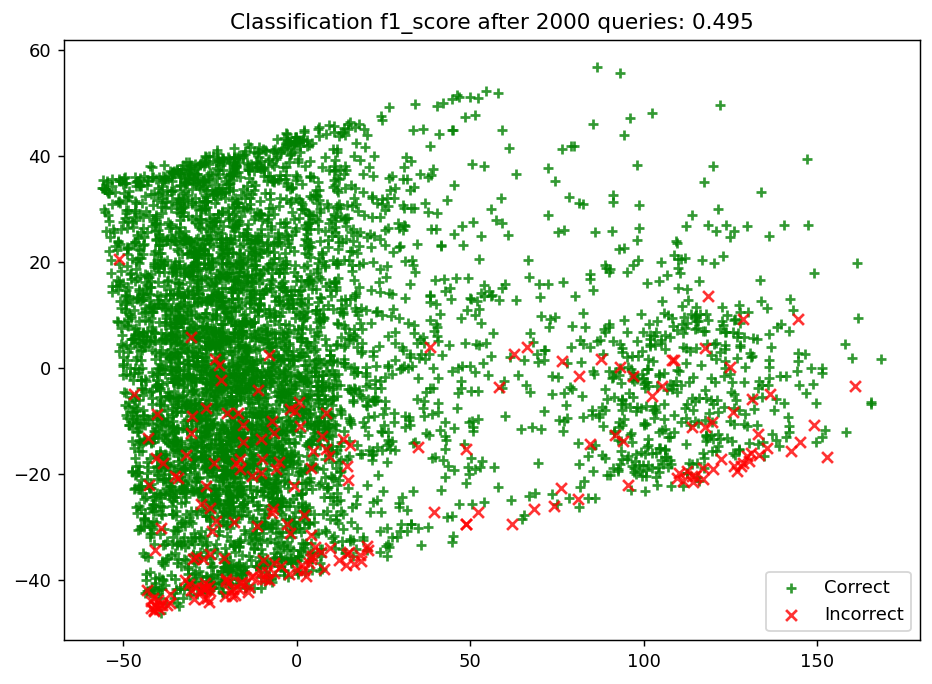

In [ ]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == y_raw)

# Plot our updated classification results once we've trained our learner.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)

ax.set_title('Classification f1_score after {n} queries: {final_acc:.3f}'.format(n=N_QUERIES, final_acc=performance_history[-1]))
ax.legend(loc='lower right')

plt.show()

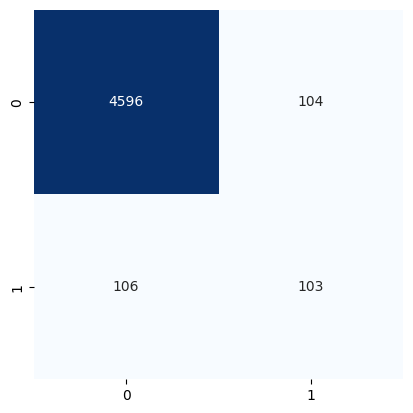

In [ ]:
predictions = learner.predict(X_raw)
conf_mat = confusion_matrix(y_raw, predictions)
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False);

# Applying Active learning using random sampling strategy

In [ ]:
X_raw1= df.drop(columns=['stroke']).values
y_raw1= df['stroke'].values

In [ ]:
# Define our PCA transformer and fit it onto our raw dataset
RANDOM_STATE_SEED = 123
np.random.seed(RANDOM_STATE_SEED)
pca = PCA(n_components=2, random_state=RANDOM_STATE_SEED)
transformed = pca.fit_transform(X=X_raw1)

In [ ]:
# Isolate our examples for our labeled dataset.
n_labeled_examples1 = X_raw1.shape[0]
training_indices1 = np.random.randint(low=0, high=n_labeled_examples1, size=10)

X_train1 = X_raw1[training_indices1]
y_train1 = y_raw1[training_indices1]

# Isolate the non-training examples we'll be querying.
X_pool1 = np.delete(X_raw1, training_indices1, axis=0)
y_pool1 = np.delete(y_raw1, training_indices1, axis=0)

In [ ]:
def random_sampling(classifier, X_pool):
    n_samples = len(X_pool)
    query_idx = np.random.choice(range(n_samples))
    return query_idx, X_pool1[query_idx]

learner = ActiveLearner(
    estimator =xgb.XGBClassifier(gamma= 1,learning_rate= 0.1,max_depth= 7,reg_lambda= 10,scale_pos_weight= 3,n_estimators=50),
    query_strategy=random_sampling,
    X_training=X_train1, y_training=y_train1
)

In [ ]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw1)
is_correct = (predictions == y_raw1)

predictions


array([1, 0, 1, ..., 0, 0, 0])

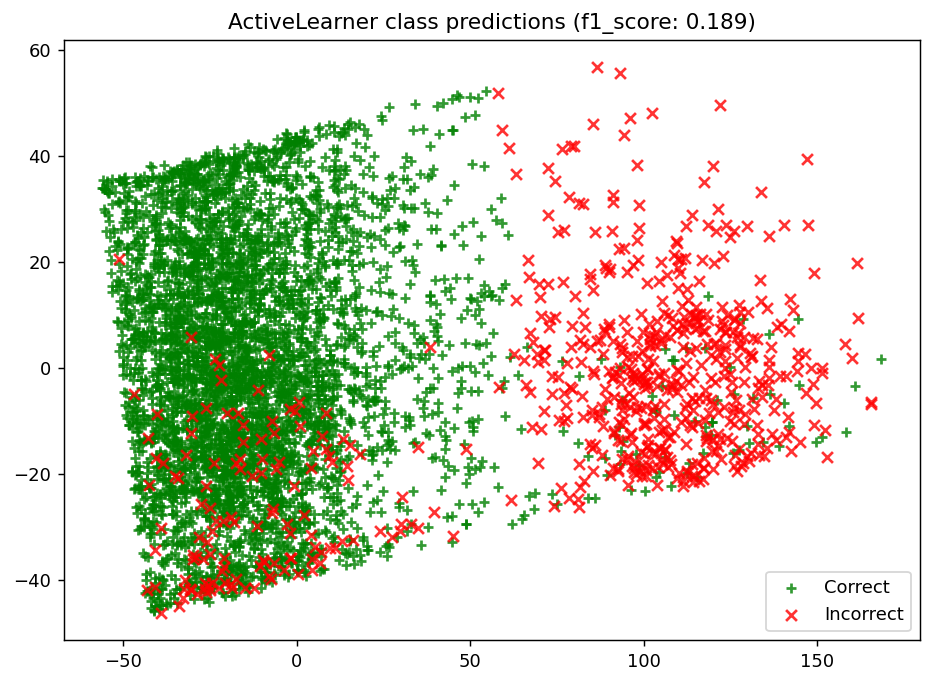

In [ ]:
# Record our learner's score on the raw data.
unqueried_score = f1_score(y_raw1, predictions)

# Plot our classification results.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)
ax.legend(loc='lower right')
ax.set_title("ActiveLearner class predictions (f1_score: {score:.3f})".format(score=unqueried_score))
plt.show()

In [ ]:
N_QUERIES = 2000
performance_history = [unqueried_score]

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
  query_index, query_instance = learner.query(X_pool1)

  # Teach our ActiveLearner model the record it has requested.
  X, y = X_pool1[query_index].reshape(1, -1), y_pool1[query_index].reshape(1, )
  learner.teach(X=X, y=y)

  # Remove the queried instance from the unlabeled pool.
  X_pool1, y_pool1 = np.delete(X_pool1, query_index, axis=0), np.delete(y_pool1, query_index)

  # Calculate and report our model's accuracy.
  if (index+1==N_QUERIES) or (index%100==0):
    predictions = learner.predict(X_raw1)
    model_f = f1_score(y_raw,predictions)
    print('f1_score after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_f))
    model_accuracy = learner.score(X_raw1, y_raw1)
    print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

    # Save our model's performance for plotting.
    performance_history.append(model_f)

f1_score after query 1: 0.1889
Accuracy after query 1: 0.8723
f1_score after query 101: 0.0474
Accuracy after query 101: 0.9509
f1_score after query 201: 0.0806
Accuracy after query 201: 0.9489
f1_score after query 301: 0.1338
Accuracy after query 301: 0.9446
f1_score after query 401: 0.2102
Accuracy after query 401: 0.9434
f1_score after query 501: 0.2118
Accuracy after query 501: 0.9454
f1_score after query 601: 0.2435
Accuracy after query 601: 0.9468
f1_score after query 701: 0.2377
Accuracy after query 701: 0.9464
f1_score after query 801: 0.2507
Accuracy after query 801: 0.9464
f1_score after query 901: 0.2667
Accuracy after query 901: 0.9507
f1_score after query 1001: 0.2711
Accuracy after query 1001: 0.9507
f1_score after query 1101: 0.2857
Accuracy after query 1101: 0.9481
f1_score after query 1201: 0.2808
Accuracy after query 1201: 0.9489
f1_score after query 1301: 0.3208
Accuracy after query 1301: 0.9448
f1_score after query 1401: 0.3187
Accuracy after query 1401: 0.9495
f1_s

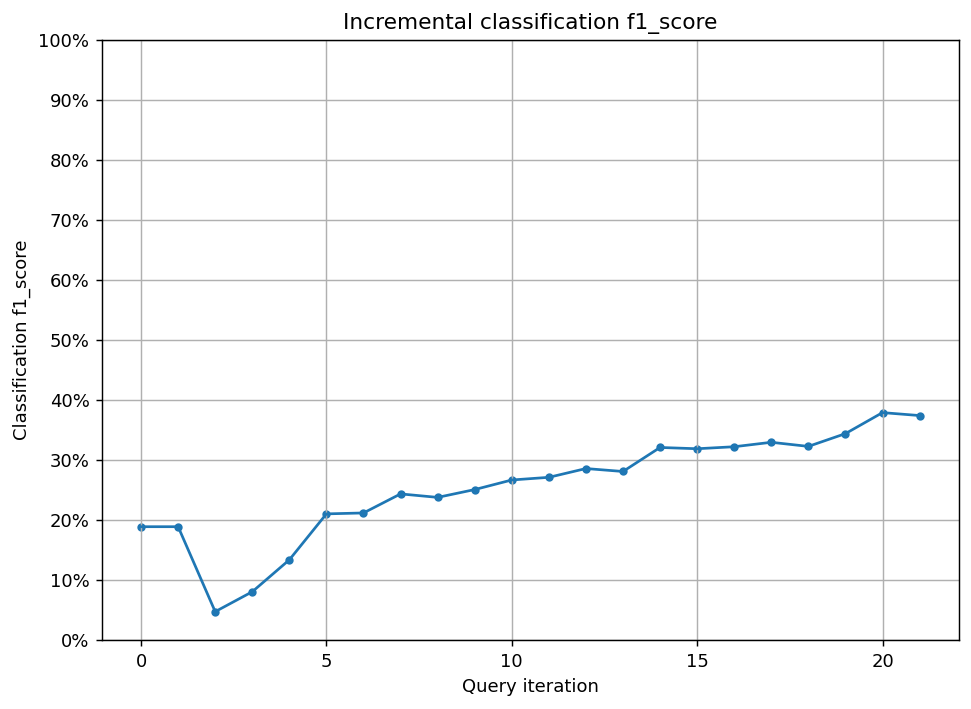

In [ ]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification f1_score')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification f1_score')

plt.show()

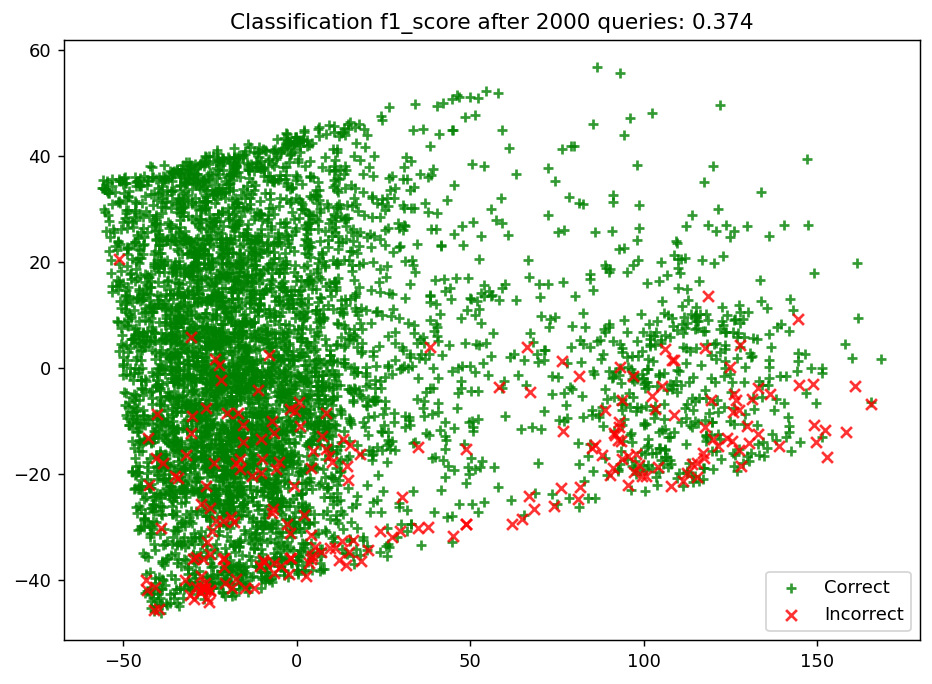

In [ ]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw1)
is_correct = (predictions == y_raw1)

# Plot our updated classification results once we've trained our learner.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)

ax.set_title('Classification f1_score after {n} queries: {final_acc:.3f}'.format(n=N_QUERIES, final_acc=performance_history[-1]))
ax.legend(loc='lower right')

plt.show()

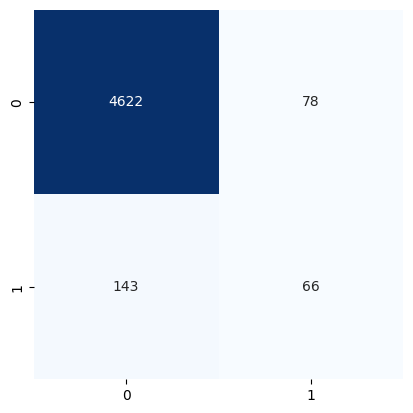

In [ ]:
predictions = learner.predict(X_raw1)
conf_mat = confusion_matrix(y_raw, predictions)
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False);

# Applying Active learning using entropy sampling strategy

In [ ]:
X_raw2= df.drop(columns=['stroke']).values
y_raw2= df['stroke'].values

In [ ]:
# Define our PCA transformer and fit it onto our raw dataset
RANDOM_STATE_SEED = 123
np.random.seed(RANDOM_STATE_SEED)
pca = PCA(n_components=2, random_state=RANDOM_STATE_SEED)
transformed = pca.fit_transform(X=X_raw2)

In [ ]:
# Isolate our examples for our labeled dataset.
n_labeled_examples2 = X_raw2.shape[0]
training_indices2 = np.random.randint(low=0, high=n_labeled_examples2, size=10)

X_train2 = X_raw2[training_indices2]
y_train2 = y_raw2[training_indices2]

# Isolate the non-training examples we'll be querying.
X_pool2 = np.delete(X_raw2, training_indices2, axis=0)
y_pool2 = np.delete(y_raw2, training_indices2, axis=0)

In [ ]:
learner = ActiveLearner(
    estimator = xgb.XGBClassifier(gamma= 1,learning_rate= 0.1,max_depth= 7,reg_lambda= 10,scale_pos_weight= 3,n_estimators=50),
    query_strategy=entropy_sampling,
    X_training=X_train2, y_training=y_train2
)

In [ ]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw2)
is_correct = (predictions == y_raw2)

predictions


array([1, 0, 1, ..., 0, 0, 0])

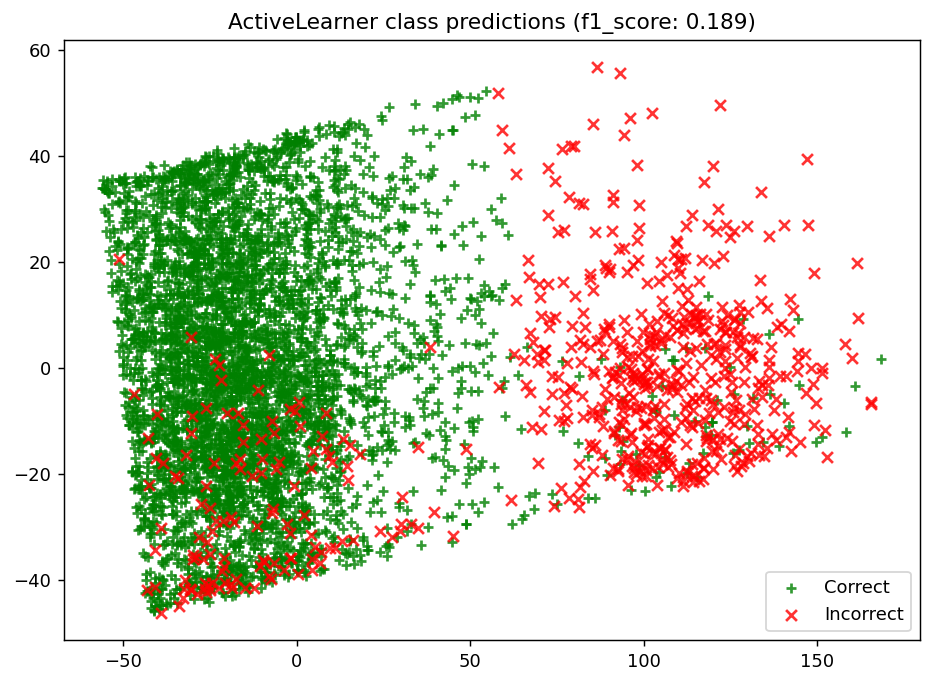

In [ ]:
# Record our learner's score on the raw data.
unqueried_score = f1_score(y_raw2, predictions)

# Plot our classification results.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)
ax.legend(loc='lower right')
ax.set_title("ActiveLearner class predictions (f1_score: {score:.3f})".format(score=unqueried_score))
plt.show()

In [ ]:
N_QUERIES = 2000
performance_history = [unqueried_score]

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
  query_index, query_instance = learner.query(X_pool2)

  # Teach our ActiveLearner model the record it has requested.
  X, y = X_pool2[query_index].reshape(1, -1), y_pool2[query_index].reshape(1, )
  learner.teach(X=X, y=y)

  # Remove the queried instance from the unlabeled pool.
  X_pool2, y_pool2 = np.delete(X_pool2, query_index, axis=0), np.delete(y_pool2, query_index)

  # Calculate and report our model's accuracy.
  if (index+1==N_QUERIES) or (index%100==0):
    predictions = learner.predict(X_raw2)
    model_f = f1_score(y_raw,predictions)
    print('f1_score after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_f))
    model_accuracy = learner.score(X_raw2, y_raw2)
    print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

    # Save our model's performance for plotting.
    performance_history.append(model_f)

f1_score after query 1: 0.1889
Accuracy after query 1: 0.8723
f1_score after query 101: 0.1161
Accuracy after query 101: 0.3551
f1_score after query 201: 0.1161
Accuracy after query 201: 0.3551
f1_score after query 301: 0.1443
Accuracy after query 301: 0.4997
f1_score after query 401: 0.1474
Accuracy after query 401: 0.5264
f1_score after query 501: 0.1474
Accuracy after query 501: 0.5264
f1_score after query 601: 0.1637
Accuracy after query 601: 0.6003
f1_score after query 701: 0.1793
Accuracy after query 701: 0.6549
f1_score after query 801: 0.2069
Accuracy after query 801: 0.7299
f1_score after query 901: 0.2230
Accuracy after query 901: 0.7629
f1_score after query 1001: 0.2460
Accuracy after query 1001: 0.8002
f1_score after query 1101: 0.2889
Accuracy after query 1101: 0.8586
f1_score after query 1201: 0.3365
Accuracy after query 1201: 0.9004
f1_score after query 1301: 0.3874
Accuracy after query 1301: 0.9246
f1_score after query 1401: 0.4092
Accuracy after query 1401: 0.9318
f1_s

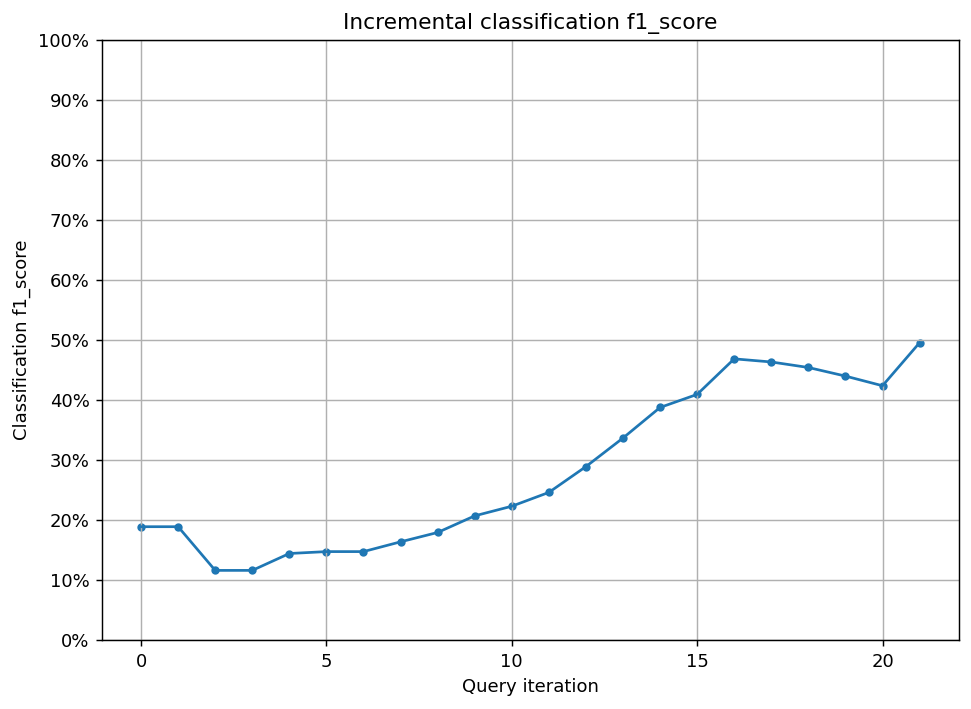

In [ ]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification f1_score')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification f1_score')

plt.show()

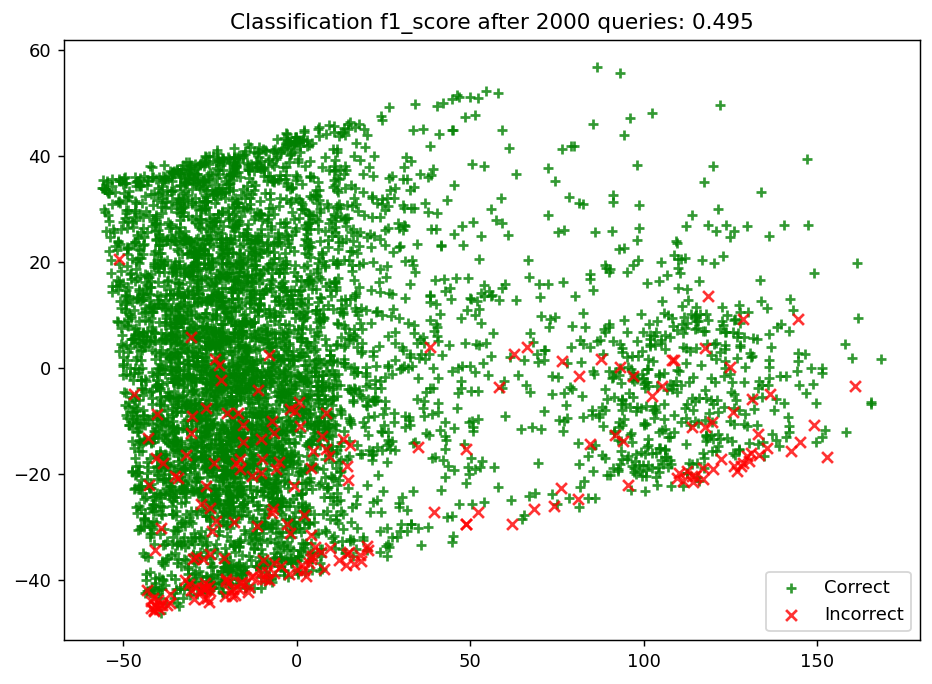

In [ ]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw2)
is_correct = (predictions == y_raw2)

# Plot our updated classification results once we've trained our learner.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)

ax.set_title('Classification f1_score after {n} queries: {final_acc:.3f}'.format(n=N_QUERIES, final_acc=performance_history[-1]))
ax.legend(loc='lower right')

plt.show()

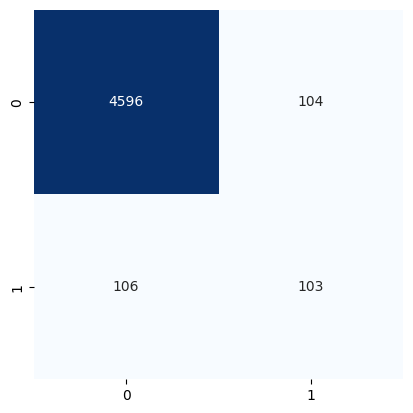

In [ ]:
predictions = learner.predict(X_raw2)
conf_mat = confusion_matrix(y_raw, predictions)
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False);

# Applying Active learning using margin sampling strategy

In [ ]:
X_raw3= df.drop(columns=['stroke']).values
y_raw3= df['stroke'].values

In [ ]:
# Define our PCA transformer and fit it onto our raw dataset
RANDOM_STATE_SEED = 123
np.random.seed(RANDOM_STATE_SEED)
pca = PCA(n_components=2, random_state=RANDOM_STATE_SEED)
transformed = pca.fit_transform(X=X_raw3)

In [ ]:
# Isolate our examples for our labeled dataset.
n_labeled_examples3 = X_raw3.shape[0]
training_indices3 = np.random.randint(low=0, high=n_labeled_examples3, size=10)

X_train3 = X_raw3[training_indices3]
y_train3 = y_raw3[training_indices3]

# Isolate the non-training examples we'll be querying.
X_pool3 = np.delete(X_raw3, training_indices3, axis=0)
y_pool3 = np.delete(y_raw3, training_indices3, axis=0)

In [ ]:
learner = ActiveLearner(
    estimator = xgb.XGBClassifier(gamma= 1,learning_rate= 0.1,max_depth= 7,reg_lambda= 10,scale_pos_weight= 3,n_estimators=50),
    query_strategy=margin_sampling,
    X_training=X_train3, y_training=y_train3
)

In [ ]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw3)
is_correct = (predictions == y_raw3)

predictions


array([1, 0, 1, ..., 0, 0, 0])

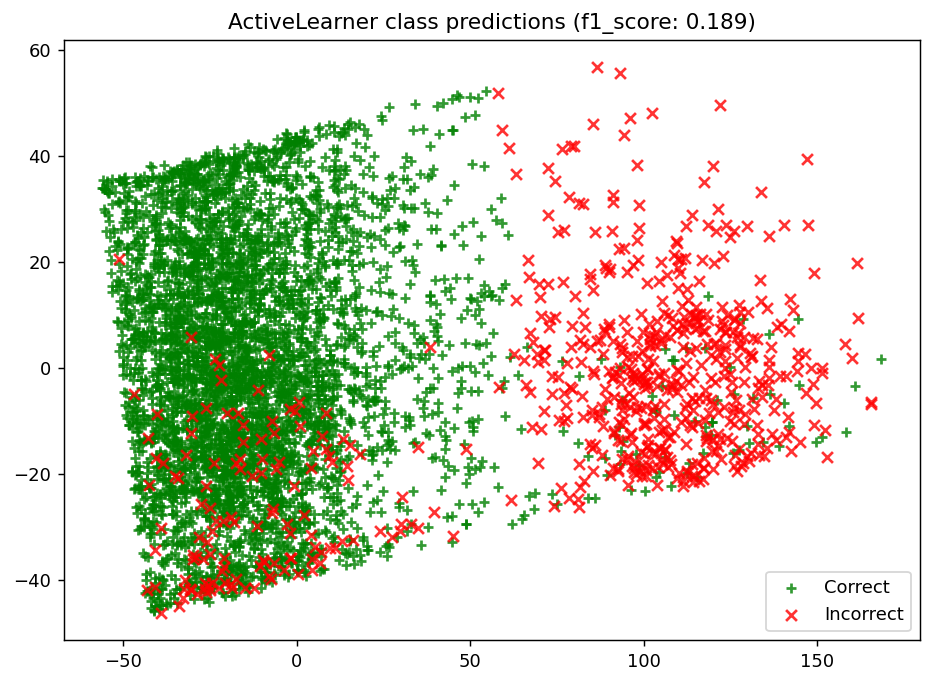

In [ ]:
# Record our learner's score on the raw data.
unqueried_score = f1_score(y_raw3, predictions)

# Plot our classification results.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)
ax.legend(loc='lower right')
ax.set_title("ActiveLearner class predictions (f1_score: {score:.3f})".format(score=unqueried_score))
plt.show()

In [ ]:
N_QUERIES = 2000
performance_history = [unqueried_score]

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy (uncertainty sampling).
for index in range(N_QUERIES):
  query_index, query_instance = learner.query(X_pool3)

  # Teach our ActiveLearner model the record it has requested.
  X, y = X_pool3[query_index].reshape(1, -1), y_pool3[query_index].reshape(1, )
  learner.teach(X=X, y=y)

  # Remove the queried instance from the unlabeled pool.
  X_pool3, y_pool3 = np.delete(X_pool3, query_index, axis=0), np.delete(y_pool3, query_index)

  # Calculate and report our model's accuracy.
  if (index+1==N_QUERIES) or (index%100==0):
    predictions = learner.predict(X_raw3)
    model_f = f1_score(y_raw,predictions)
    print('f1_score after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_f))
    model_accuracy = learner.score(X_raw3, y_raw3)
    print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

    # Save our model's performance for plotting.
    performance_history.append(model_f)

f1_score after query 1: 0.1889
Accuracy after query 1: 0.8723
f1_score after query 101: 0.1161
Accuracy after query 101: 0.3551
f1_score after query 201: 0.1161
Accuracy after query 201: 0.3551
f1_score after query 301: 0.1443
Accuracy after query 301: 0.4997
f1_score after query 401: 0.1474
Accuracy after query 401: 0.5264
f1_score after query 501: 0.1474
Accuracy after query 501: 0.5264
f1_score after query 601: 0.1637
Accuracy after query 601: 0.6003
f1_score after query 701: 0.1793
Accuracy after query 701: 0.6549
f1_score after query 801: 0.2069
Accuracy after query 801: 0.7299
f1_score after query 901: 0.2230
Accuracy after query 901: 0.7629
f1_score after query 1001: 0.2460
Accuracy after query 1001: 0.8002
f1_score after query 1101: 0.2889
Accuracy after query 1101: 0.8586
f1_score after query 1201: 0.3365
Accuracy after query 1201: 0.9004
f1_score after query 1301: 0.3874
Accuracy after query 1301: 0.9246
f1_score after query 1401: 0.4092
Accuracy after query 1401: 0.9318
f1_s

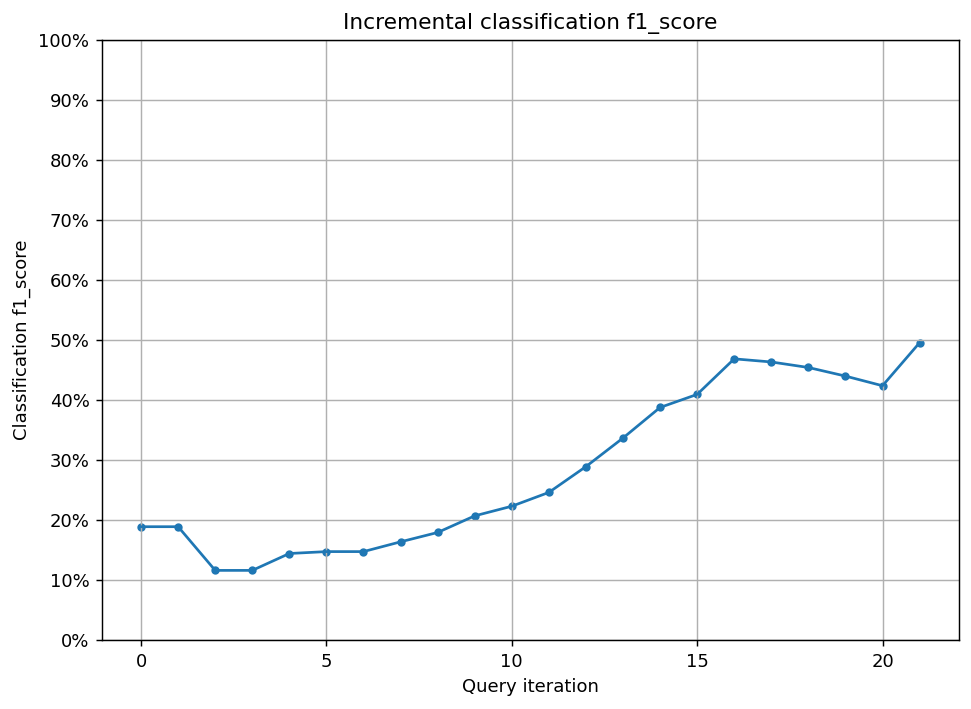

In [ ]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification f1_score')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification f1_score')

plt.show()

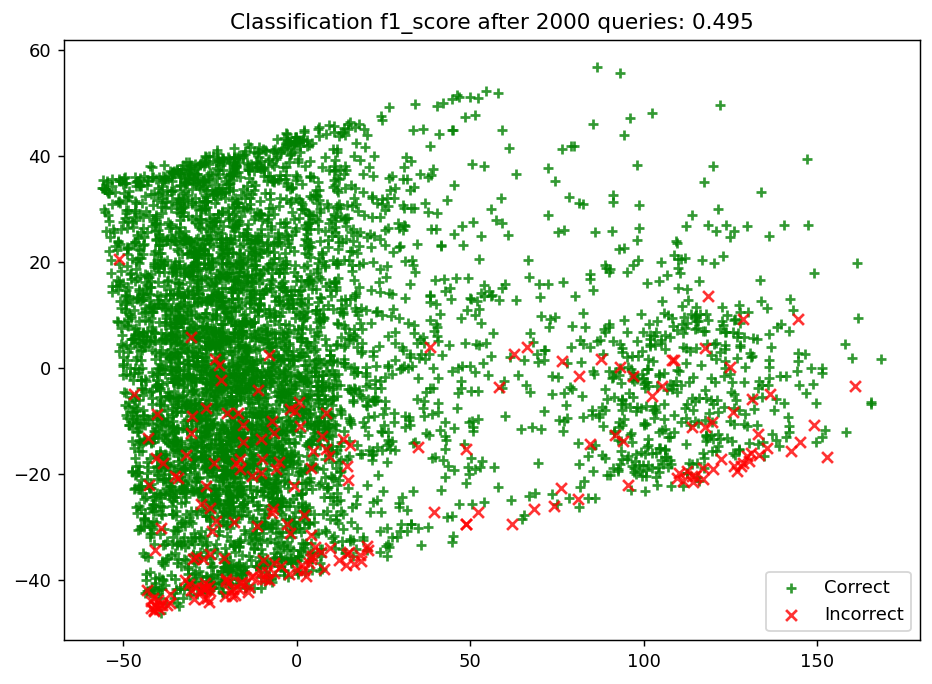

In [ ]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw3)
is_correct = (predictions == y_raw3)

# Plot our updated classification results once we've trained our learner.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.scatter(x=x_component[is_correct],  y=y_component[is_correct],  c='g', marker='+', label='Correct',   alpha=8/10)
ax.scatter(x=x_component[~is_correct], y=y_component[~is_correct], c='r', marker='x', label='Incorrect', alpha=8/10)

ax.set_title('Classification f1_score after {n} queries: {final_acc:.3f}'.format(n=N_QUERIES, final_acc=performance_history[-1]))
ax.legend(loc='lower right')

plt.show()

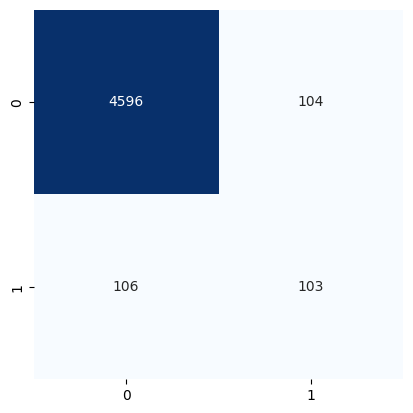

In [ ]:
predictions = learner.predict(X_raw3)
conf_mat = confusion_matrix(y_raw, predictions)
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False);